In [3]:
#@title imports
import os
import pickle
from typing import Set
import numpy as np
from numpy.lib.function_base import append
import scipy.io as spio
from scipy.io import loadmat, savemat
import importlib.util
from sklearn import datasets, linear_model
from scipy.sparse import data

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle as pkl
from pylab import *


In [ ]:
#@title connect gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
#@title utils
def loadmat_(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    if ('analyzed' in filename )and ('_CC_' not in filename):
        Data = []
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        try:
            for i in range(len(data)):
                data_ = data[i]
                data_ = _todict(data_)
                Data.append(_check_keys(data_))
            return Data
        except:
            data_ = data
            data_ = _todict(data_)
            Data.append(_check_keys(data_))
            return Data
    elif ('analyzed' in filename) and ('_CC_' in filename):
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        data = _todict(data)
    else:
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        data = _todict(data)
    return _check_keys(data)


def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict

def _todict(matobj):
    '''
    A recursive function which constructs nested dictionaries from matobjects
    '''
    dict = {}
    try:
      for strg in matobj._fieldnames:
          elem = matobj.__dict__[strg]
          if isinstance(elem, spio.matlab.mio5_params.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:

              dict[strg] = elem
    except:
        for strg in matobj.keys():
          elem = matobj[strg]
          if isinstance(elem, spio.matlab.mio5_params.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:

              dict[strg] = elem
    return dict
def join_cond(lis_cond = None):
  path = '/content/gdrive/MyDrive/lists/all_files_new.csv'
  a = pd.read_csv(path)
  cond= np.sort(np.unique(a['condition']))
  temp = []
  if lis_cond ==None:
    return a
  if len(lis_cond)>1:
    for i in lis_cond:
      temp.append(a.groupby('condition').get_group(i))
    new_df = temp[0]
    for j in range(1,len(temp)):
      new_df = pd.concat([new_df,temp[j]])
  else:
    new_df = a.groupby('condition').get_group(lis_cond[0])
  return new_df
#@title impedence functions
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
import numpy.matlib

def makespectrumt(trace, timelen,adcrate):
    # time is the timelength of the sub evaluation 1/time is the freq resolution!
    NFFT  = timelen * adcrate

    NFFT2 = int(np.floor(NFFT/2))
    NFFT  = int(2 * NFFT2)
    fas   = np.arange(0,NFFT2-1,(1/timelen)) #(0:(1/timelen):(NFFT2-1)/timelen)'
    fwdw  = signal.windows.hamming(NFFT)
    start = 0
    last  = len(trace)-NFFT
    count = 0
    pwr = 0
    while start<last:
        endpoint = start + NFFT
        spoor = trace[start:endpoint]-np.mean(trace[start:endpoint])
        spect = fft(fwdw*spoor,NFFT)/NFFT
        if count == 0:
          pwr = 2*np.abs(spect[1:NFFT2])
        else:
          pwr = pwr + 2*np.abs(spect[1:NFFT2])
        start = start + NFFT2
        count += 1
    pwr = pwr/count
    return pwr, fas


def overdracht_wytse(par1, spoordac, spooradc, dacrate, adcrate, par2=None):

    time = par1;
    if par2 is None:
      nf = 0
    else:
      nf = par2
    [pwrdac, fasdac] = makespectrumt(spoordac,time,dacrate)
    [pwradc, fasadc] = makespectrumt(spooradc,time,adcrate)
    lendac = len(pwrdac)
    lenadc = len(pwradc)
    if lendac>lenadc:
        pwrdac = pwrdac[1:lenadc]
        fas = fasdac[1:lenadc]
    elif lenadc>lendac:
      pwradc = pwradc[1:lendac]
      fas = fasadc[1:lendac]
    else:
        fas = fasdac

    if nf>1:
        pwrdac = signal.filtfilt(np.matlib.repmat(1/nf,nf,1),1,pwrdac)
        pwradc = signal.filtfilt(np.matlib.repmat(1/nf,nf,1),1,pwradc)
    ovr = pwradc/pwrdac

    y=ovr
    return y


def spectrum_wytse(spoor,rate, par1, par2=None):
    time = par1
    if par2==None: nf = 0
    else: nf = par2

    [pwr,fas] = makespectrumt(spoor,time,rate)

    if nf>1: pwr = scipy.signal.filtfilt(np.matlib.repmat(1/nf,nf,1),1,pwr)
    x=pwr
    y=fas
    return (x,y)

def  return_stiched_spike_train(data,subthreshold =False,plot=False):

    V= data['membrane_potential']
    I= data['input_current']
    spikes = data['spikeindices']
    if data['input_generation_settings']['tau'] == 250:
        left = 20
        right = 30
    else:
        left = 20
        right = 20
    empty_cell = []
    for i in spikes:
        empty_cell.append([np.arange(i-left,i+right)])
        V1 = V[i-left]
        V2 = V[i+right]
        if V1!=V2:
            div = (V2-V1)/(left+right)
            V[i-left:i+right] = np.arange(V1,V2,div)[:left+right]
        else:
            V[i-left:i+right] = np.ones((1,left+right))*V1

        I1 = I[i-left]
        I2 = I[i+right]
        if I1!=I2:
            divI = (I2-I1)/(left+right)

            I[i-left:i+right] = np.arange(I1,I2,divI)[:left+right]
        else:

            I[i-left:i+right] = np.ones((1,left+right))*I1

    V_ = V
    I_ = I
    tailored_spikes = np.ndarray.flatten(np.array(empty_cell))    #{cat(2, empty_cell{:})}
    zero_spikes = np.zeros(np.size(V))
    zero_spikes[tailored_spikes] = True

    if subthreshold == True:
        zero_spikes = ~zero_spikes

    return zero_spikes,V_,I_

def getAllFilesInDir(path):
  all_files = []
  all_dirs = []

  for i, j, k in os.walk(path):
    #  print("path =", i)
    #  print("List of directories =", j)
    #  print("List of files =", k)
    all_dirs = np.concatenate((all_dirs,[i+'/' for i in j]))

    all_files = np.concatenate((all_files,k))
  return(all_files,np.append(np.unique([all_dirs]),''))

In [206]:
getAllFilesInDir('D:/NC_CC_files/mat_analyzed/mat_analyzed')

(array(['analyzed_CC_171222_NC_160_CC.mat',
        'analyzed_CC_171220_NC_159_CC.mat',
        'analyzed_CC_171222_NC_161_CC.mat',
        'analyzed_CC_171220_NC_158_CC.mat',
        'analyzed_CC_171220_NC_155_CC.mat',
        'analyzed_CC_171220_NC_157_CC.mat',
        'analyzed_CC_171207_AB_22_CC.mat',
        'analyzed_CC_171207_NC_150_CC.mat',
        'analyzed_CC_171208_NC_151_CC.mat',
        'analyzed_CC_171211_NC_154_CC.mat',
        'analyzed_CC_171207_NC_149_CC.mat',
        'analyzed_CC_171207_NC_146_CC.mat',
        'analyzed_CC_171207_NC_148_CC.mat',
        'analyzed_CC_171208_NC_152_CC.mat',
        'analyzed_CC_171211_NC_153_CC.mat',
        'analyzed_CC_171207_NC_147_CC.mat',
        'analyzed_CC_171017_NC_142_CC.mat',
        'analyzed_CC_171220_NC_156_CC.mat',
        'analyzed_CC_171110_NC_143_CC.mat',
        'analyzed_CC_171110_NC_145_CC.mat',
        'analyzed_CC_171017_KK_13_CC.mat',
        'analyzed_CC_171110_NC_144_CC.mat',
        'analyzed_CC_171012_NC_138

In [227]:
#@title loading paths and getting all the files as lists
path_fn = 'G:/My Drive/lists/all_files_new.csv' 
metadata_path = 'G:/My Drive/lists/Metadata.xlsx'
no_fn = pd.read_excel("G:/My Drive/lists/All_no_FN_cells.xlsx")
all_files_fn = pd.read_csv(path_fn)['experimentname']
all_files_fn = np.unique(all_files_fn)
count_fn =0
count_cc =0 
# path_cc = '/content/gdrive/MyDrive/Step-and-Hold Protocol (Xuan, Asli, NC, Payam)/'
path_cc = 'D:/NC_CC_files/mat_analyzed/mat_analyzed/'
path_exc = 'G:/My Drive/StepAndHold Dataset/CC - Excitatory/Raw CC/'
path_inh = 'G:/My Drive/StepAndHold Dataset/CC - Inhibitory/Raw CC/'
path_exc_analyzed = 'G:/My Drive/StepAndHold Dataset/CC - Excitatory/Analyzed/'
path_inh_analyzed = 'G:/My Drive/StepAndHold Dataset/CC - Inhibitory/Analyzed/'

all_files_cc,all_files_cc_dirs = getAllFilesInDir(path_cc)
all_files_cc_exc,all_files_cc_exc_dirs = getAllFilesInDir(path_exc)
all_files_cc_inh,all_files_cc_inh_dirs = getAllFilesInDir(path_inh)
all_files_cc_exc_analyzed,all_files_cc_exc_analyzed_dirs = getAllFilesInDir(path_exc_analyzed)
all_files_cc_inh_analyzed,all_files_cc_inh_analyzed_dirs = getAllFilesInDir(path_inh_analyzed)

all_fn_files_raw,_ = getAllFilesInDir('G:/MyDrive/Raw/')
all_cc_complete = np.concatenate((all_files_cc,np.concatenate((all_files_cc_inh,all_files_cc_exc))))
all_cc_analyzed = np.concatenate((all_files_cc_exc_analyzed,all_files_cc_inh_analyzed))
all_cc_raw = np.concatenate((all_files_cc_exc,all_files_cc_inh))

In [229]:
# path_analyzed  = 'G:/My Drive/Analyzed/'
# for i in os.listdir(path_analyzed):
#     if 'Copy of ' in i:
#         os.rename(path_analyzed+i,path_analyzed+i.split(' ')[2])


array(['analyzed_CC_171222_NC_160_CC.mat',
       'analyzed_CC_171220_NC_159_CC.mat',
       'analyzed_CC_171222_NC_161_CC.mat',
       'analyzed_CC_171220_NC_158_CC.mat',
       'analyzed_CC_171220_NC_155_CC.mat',
       'analyzed_CC_171220_NC_157_CC.mat',
       'analyzed_CC_171207_AB_22_CC.mat',
       'analyzed_CC_171207_NC_150_CC.mat',
       'analyzed_CC_171208_NC_151_CC.mat',
       'analyzed_CC_171211_NC_154_CC.mat',
       'analyzed_CC_171207_NC_149_CC.mat',
       'analyzed_CC_171207_NC_146_CC.mat',
       'analyzed_CC_171207_NC_148_CC.mat',
       'analyzed_CC_171208_NC_152_CC.mat',
       'analyzed_CC_171211_NC_153_CC.mat',
       'analyzed_CC_171207_NC_147_CC.mat',
       'analyzed_CC_171017_NC_142_CC.mat',
       'analyzed_CC_171220_NC_156_CC.mat',
       'analyzed_CC_171110_NC_143_CC.mat',
       'analyzed_CC_171110_NC_145_CC.mat',
       'analyzed_CC_171017_KK_13_CC.mat',
       'analyzed_CC_171110_NC_144_CC.mat',
       'analyzed_CC_171012_NC_138_CC.mat',
       'analy

In [210]:

all_files_cc_NC = list(set(all_files_cc[['NC' in i for i in all_files_cc]]))
all_files_fn_NC = list(set(all_files_fn[['NC' in i for i in all_files_fn]]))
# NC_no_fn = no_fn['File name'][['NC' in i for i in list(no_fn['File name'])]]

# dates = [i.split('_')[2] for i in NC_no_fn]
# NC_un = np.unique(dates,return_counts=True)
# pd.DataFrame({'dates':NC_un[0],'counts':NC_un[1]})
all_files_fn_NC


['NC_170830_aCSF_D1ago_E3',
 'NC_171207_aCSF_E6',
 'NC_170815_aCSF_D1ago_E6',
 'NC_171012_aCSF_D1ago_E5',
 'NC_171207_aCSF_E4',
 'NC_170815_aCSF_D1ago_E1',
 'NC_170814_aCSF_D1ago_E9',
 'NC_170626_aCSF_D1ago_E2',
 'NC_170816_aCSF_D1ago_E1',
 'NC_171220_aCSF_D1ago_E5',
 'NC_170630_aCSF_D1ago_E3',
 'NC_170713_aCSF_DopD2D1_E3',
 'NC_171011_aCSF_D1ago_E1',
 'NC_171219_aCSF_BIC_E2',
 'NC_170718_aCSF_DopD2D1_E1',
 'NC_171006_aCSF_D1ago_E4',
 'NC_170719_aCSF_DopD2D1_E3',
 'NC_171219_aCSF_BIC_E1',
 'NC_170724_aCSF_DopD2D1_E4',
 'NC_170717_aCSF_DopD2D1_E3',
 'NC_170714_aCSF_DopD2D1_E4',
 'NC_171218_aCSF_BIC_E2',
 'NC_170815_aCSF_D1ago_E2',
 'NC_170821_aCSF_D1ago_E4',
 'NC_171010_aCSF_D1ago_E2',
 'NC_171017_aCSF_D1ago_E4',
 'NC_170703_aCSF_D1ago_E5',
 'NC_171207_aCSF_E1',
 'NC_171207_aCSF_E3',
 'NC_170815_aCSF_D1ago_E5',
 'NC_170718_aCSF_DopD2D1_E2',
 'NC_171211_aCSF_BIC_E1',
 'NC_171207_aCSF_E5',
 'NC_170811_aCSF_D1ago_E4',
 'NC_171011_aCSF_D1ago_E3',
 'NC_171006_aCSF_D1ago_E7',
 'NC_170627_DopD

In [226]:
dates_cc = np.unique([i.split('_')[2] for i in all_files_cc_NC],return_counts=True)
dates_fn = np.unique([i.split('_')[1] for i in all_files_fn_NC],return_counts=True)

df_dates_FN = pd.DataFrame({'Dates_FN':dates_fn[0],'Count_FN':dates_fn[1]})
df_dates_CC = pd.DataFrame({'Dates_CC':dates_cc[0],'Count_CC':dates_cc[1]})
df = pd.concat([df_dates_FN,df_dates_CC])
for i,j in zip(df_dates.columns,[dates_fn[0],dates_cc[0],dates_fn[1],dates_cc[1]]):
    df_dates[i] = j

FN_ = []
CC_ = []
files_FN = [] 
files_CC = [] 

for d in dates_cc:
    date.append(d)
    FN_.append(len(np.array(all_files_fn_NC)[[d in i for i in np.array(all_files_fn_NC)]]))
    CC_.append(len(np.array(all_files_cc_NC)[[d in i for i in np.array(all_files_cc_NC)]]))
    files_CC.append(np.array(all_files_cc_NC)[[d in i for i in np.array(all_files_cc_NC)]])
    files_FN.append(np.array(all_files_fn_NC)[[d in i for i in np.array(all_files_fn_NC)]])

df = pd.DataFrame({'dates':date,'FN':FN_,'CC':CC_,'diff':np.array(FN_)-np.array(CC_),'files_cc':files_CC,'files_fn':files_FN})
df.to_excel('D:/lists/compare_missing_FN_CC_NC.xlsx')



In [6]:
#@title loading the metadata excel sheet for comparison
meta = pd.read_excel(metadata_path)
meta = meta.dropna()
print(meta.columns)
def add_(data):
  return '_'+data
def convert_to_string(data):
  return str(int(data))
meta[['date (DD.MM.YY)','Experiment\nnumber','prefix']]
join_meta = meta['prefix']+meta['date (DD.MM.YY)'].apply(convert_to_string).apply(add_)+meta['Experiment\nnumber'].apply(add_)


Index(['date (DD.MM.YY)', 'Experiment\nnumber', 'Animal \nnumber', 'prefix',
       'Age(p)', 'sex', 'Experiment\nprotocol', 'classification', 'Agonist'],
      dtype='object')


In [22]:
NC_data_translation =  pd.read_excel('/content/gdrive/MyDrive/StepAndHold Dataset/CC Step Data Names Map Translationods.xlsx')
FN = NC_data_translation['FN'][[type(i)==str for i in NC_data_translation['FN']]]
CC = NC_data_translation['CC'][[type(i)==str for i in NC_data_translation['FN']]]
df_cc_fn = pd.DataFrame({'cc':pd.Series(CC),'fn':pd.Series(FN)})


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/StepAndHold Dataset/CC Step Data Names Map Translationods.xlsx'

In [134]:
type((np.zeros(10)*np.nan)[0])

numpy.float64

In [137]:
def find_matches(list1,list2):
  matches = 0
  matches_return = np.zeros(len(list2),dtype=object)*np.nan
  not_match = []
  for i in range(len(list1)):
    for j in range(len(list2)):
      if list1[i] == list2[j]:
        matches+=1
        matches_return[j] = list2[j]
  return matches,matches_return

def return_df_with_info(df,experimenter=None, condition=None):
  selected_experimenter = pd.read_csv(path_fn)[pd.read_csv(path_fn)['experimenter']==experimenter]
  selected_experimenter_cond = np.unique(selected_experimenter['condition'])
  selected_experimenter_cond_df =  selected_experimenter[selected_experimenter['condition'] ==condition]
  return selected_experimenter, selected_experimenter_cond
df, cond = return_df_with_info(pd.read_csv(path_fn),'NC',)

D1_NC = df[df['condition']=='D1']['experimentname']

In [20]:
def return_name_string_obj_NC(data):
  broken_str = data.split('_')
  if 'NC' == broken_str[2]:
    name = broken_str[2]
    date = broken_str[3]
    return name+'_'+date
  else:
    name = broken_str[3]
    date = broken_str[2]
    return name+'_'+date
def modify_names(file_name):
  str_temp = file_name
  print(str_temp)
  all_parts = str_temp.split('_')
  name = all_parts[0]
  if 'Payam' == name:
    name = name.lower()
  broken = all_parts[1].split('-')
  date = broken[:3]
  date = date[0]+date[1]+date[2]
  exp = broken[3]
  return name+'_'+date+'_'+exp


NC = []
Payam = []
asli = []
KK = []
xuan = []
for i in all_cc_analyzed:
  if 'NC' in i:
    NC.append(i)
  elif 'Payam' in i:
    Payam.append(i)
  elif 'asli' in i:
    asli.append(i)
  elif 'KK' in i:
    KK.append(i)
  elif 'xuan' in i:
    xuan.append(i)
NC_analyzed = [return_name_string_obj_NC(i) for i in NC]


In [23]:
def return_name_date_exp_fn(string):
  if 'NC' in string:
    string_broken = string.split('_')
    name = string_broken[0]
    date = string_broken[1]
    exp = string_broken[-1]
    year = date[:2]
    month = date[2:4]

    if month[0] =='0':
      month = month[1]
    day = date[4:]
    if day[0] =='0':
      day = day[1]
    date = day+month+year
    return name+'_'+date+'_'+exp
  elif 'xuan' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp
  elif 'asli' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp
  elif 'Payam' in string:
    broken_str = string.split('_')
    name = broken_str[0].lower()
    date = broken_str[1].split('-')
    exp =  broken_str[2]
    day = date[0]
    month = date[1]
    year = date[2]
    if day[0] =='0':
      day=day[1]
    date = day+month+year
    return name+'_'+date+'_'+exp

all_cc_names_and_dates = [modify_names(i) for i in all_files_cc]

df_all_fn = pd.read_csv(path_fn)

selected_experimenter_cond = np.unique(df_all_fn['condition'])
print(selected_experimenter_cond)
conds = ['DOPA', 'DOPAMINE' ,'Dop']
all_fn_names_and_dates = np.array(join_cond(conds)['experimentname'].apply(return_name_date_exp_fn))
# print(all_fn_names_and_dates)
nummatch,matches = find_matches(np.unique(all_fn_names_and_dates),np.unique(all_cc_names_and_dates))
df_CC_exp = pd.DataFrame({'CC_files':all_files_cc,'all_cc_names_and_dates':all_cc_names_and_dates})
df_CC_exp['drug'] =~np.array(['NODRUG' in i for i in df_CC_exp['CC_files']])


analyzed_CC_171222_NC_160_CC.mat


IndexError: list index out of range

In [23]:
def mod_meta(string):
  string_break = string.split('_')
  name = string_break[0]
  date = string_break[1]
  exp = string_break[2]

  if len(date)==5:
    day = date[0]
    month = date[1:3]
    if month[0] =='0':
      month=month[1]
    year = date[3:]
  elif len(date)==6:
    day = date[:2]
    month = date[2:4]
    if month[0] =='0':
      month=month[1]
    year = date[4:]
  return name+'_'+day+month+year+'_'+exp
mod_join_meta = [mod_meta(i) for i in join_meta]
# print(len(np.unique(mod_join_meta)),len(np.unique(all_cc_names_and_dates)))
meta['exp_name'] = mod_join_meta
meta


,date (DD.MM.YY),Experiment\nnumber,Animal \nnumber,prefix,Age(p),sex,Experiment\nprotocol,classification,Agonist,infile,exp_name
0,30719.0,E1,A1,xuan,241.0,M,"CC40pA, FN",excitatory,5HT-1f(S1 cortex),True,xuan_3719_E1
1,30719.0,E2,A1,xuan,241.0,M,"CC40pA, FN",excitatory,5HT-1f(S1 cortex),True,xuan_3719_E2
2,30719.0,E3,A1,xuan,241.0,M,"CC40pA, FN",excitatory,5HT-1f(S1 cortex),True,xuan_3719_E3
3,30719.0,E4,A1,xuan,241.0,M,"CC40pA, FN",excitatory,5HT-1f(S1 cortex),True,xuan_3719_E4
4,70619.0,E1,A2,xuan,229.0,F,"CC40pA, FN",excitatory,5HT-1f(S1 cortex),True,xuan_7619_E1
...,...,...,...,...,...,...,...,...,...,...,...
229,150817.0,E3,A94,NC,118.0,F,"CC40pA, FN",inhibitory,D1,True,NC_15817_E3
230,160817.0,E1,A103,NC,79.0,F,"CC40pA, FN",inhibitory,D1,True,NC_16817_E1
231,160817.0,E2,A103,NC,79.0,F,"CC40pA, FN",inhibitory,D1,True,NC_16817_E2
232,300817.0,E1,A96,NC,285.0,F,"CC40pA, FN",inhibitory,D1,True,NC_30817_E1


In [138]:
#@title find matches between CC and metadata
num,matches = find_matches(mod_join_meta,all_cc_names_and_dates)
df_CC_exp['matches']  =matches
print(str(num)+' matches out of '+str(len(all_cc_names_and_dates))+' files in CC database')
truth_table =  np.zeros(len(mod_join_meta),dtype=bool)
for ind,filen, in enumerate(mod_join_meta):
  for j in matches:
    if filen==j:
      truth_table[ind] = True
meta['infile'] = truth_table
all_ago = np.unique(meta['Agonist'])
all_cond_dict = {}
def return_str(data):
  return str(int(data))
for i in all_ago:
  exp = meta[meta['Agonist']==i]['prefix']+'_'+meta[meta['Agonist']==i]['date (DD.MM.YY)'].apply(return_str)+'_'+meta[meta['Agonist']==i]['Experiment\nnumber']
  all_cond_dict[i] = {'Agonist_num':sum(meta[meta['Agonist']==i]['infile']),'exp':exp}
for key, vals in all_cond_dict.items():
  print(key, vals['Agonist_num'])

320 matches out of 320 files in CC database
5HT-1f(S1 cortex) 6
5HT1f(M1 cortex） 39
Alpha1 40
D1 23
D2 14
M1 42
dopamine 3


In [34]:
df_CC_exp['classification'] = df_CC_exp['all_cc_names_and_dates'].map(meta.set_index('exp_name')['classification'])
def lower(data):
    return data.lower()
df_CC_exp.classification = df_CC_exp.classification.apply(lower)


,CC_files,all_cc_names_and_dates,drug,condition,matches,classification
0,xuan_23-10-18-E1-CCSTEP-DRUG.mat,xuan_231018_E1,True,D2,xuan_231018_E1,excitatory
1,xuan_23-10-18-E1-CCSTEP-NODRUG.mat,xuan_231018_E1,False,D2,xuan_231018_E1,excitatory
2,xuan_23-11-18-E2-CCSTEP-NODRUG.mat,xuan_231118_E2,False,D2,xuan_231118_E2,excitatory
3,xuan_25-5-20-E2-CCSTEP-DRUG.mat,xuan_25520_E2,True,5HT1f(M1 cortex）,xuan_25520_E2,inhibitory
4,xuan_25-5-20-E2-CCSTEP-NODRUG.mat,xuan_25520_E2,False,5HT1f(M1 cortex）,xuan_25520_E2,inhibitory
...,...,...,...,...,...,...
315,xuan_20-9-19-E2-CCSTEP-NODRUG.mat,xuan_20919_E2,False,Alpha1,xuan_20919_E2,excitatory
316,xuan_20-9-19-E3-CCSTEP-DRUG.mat,xuan_20919_E3,True,Alpha1,xuan_20919_E3,excitatory
317,xuan_20-9-19-E3-CCSTEP-NODRUG.mat,xuan_20919_E3,False,Alpha1,xuan_20919_E3,excitatory
318,xuan_21-1-19-E5-CCSTEP-DRUG.mat,xuan_21119_E5,True,D2,xuan_21119_E5,inhibitory


In [35]:
df_CC_exp['condition'] = ''
for i in all_cond_dict:
  df_CC_exp['condition'][np.array(df_CC_exp['all_cc_names_and_dates'].isin(all_cond_dict[i]['exp'].apply(mod_meta)))] = i
  # df_CC_exp[df_CC_exp['CC_files'].str.contains('NODRUG')]['condition']
ind = df_CC_exp['drug']==False


df_CC_exp.to_csv('/content/gdrive/MyDrive/lists/all_cc_with_condition.csv')
df_CC_exp[df_CC_exp['condition'] =='5HT-1f(S1 cortex)'][ind]


<ipython-input-35-2e0c39ee5054>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-35-2e0c39ee5054>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,CC_files,all_cc_names_and_dates,drug,condition,matches,classification
17,xuan_26-6-19-E6-CCSTEP-NODRUG.mat,xuan_26619_E6,False,5HT-1f(S1 cortex),xuan_26619_E6,inhibitory
251,xuan_5-6-19-E3-CCSTEP-NODRUG.mat,xuan_5619_E3,False,5HT-1f(S1 cortex),xuan_5619_E3,inhibitory
253,xuan_5-6-19-E4-CCSTEP-NODRUG.mat,xuan_5619_E4,False,5HT-1f(S1 cortex),xuan_5619_E4,excitatory
264,xuan_9-7-19-E4-CCSTEP-NODRUG.mat,xuan_9719_E4,False,5HT-1f(S1 cortex),xuan_9719_E4,inhibitory
290,xuan_13-6-19-E1-CCSTEP-NODRUG.mat,xuan_13619_E1,False,5HT-1f(S1 cortex),xuan_13619_E1,inhibitory


In [53]:
#@title find matches between FN and CC files

num,matches = find_matches(np.unique(df_all_fn['experimentname'].apply(return_name_date_exp_fn)),all_cc_names_and_dates)
print(str(num) + ' matches out of '+str(len(np.unique(df_all_fn['experimentname'].apply(return_name_date_exp_fn))))+' FN files')
truth_table =  np.zeros(len(mod_join_meta),dtype=bool)
for ind,filen, in enumerate(mod_join_meta):
  for j in matches:
    if filen==j:
      truth_table[ind] = True
meta['infile'] = truth_table
all_ago = np.unique(meta['Agonist'])
all_cond_dict = {}
for i in all_ago:
   all_cond_dict[i] = sum(meta[meta['Agonist']==i]['infile'])
all_cond_dict

221 matches out of 323 FN files


{'5HT-1f(S1 cortex)': 3,
 '5HT1f(M1 cortex）': 0,
 'Alpha1': 39,
 'D1': 22,
 'D2': 14,
 'M1': 37,
 'dopamine': 2}

In [147]:
matches[4] is (np.zeros(1,dtype=object)*np.nan)[0]


False

In [58]:
df_CC_exp['fn_matches'] = matches
df_CC_exp.to_csv('/content/gdrive/MyDrive/lists/Verification_list_all_CC_FN.csv')

In [169]:
df_acsf = df_CC_exp[df_CC_exp.drug==False]
len(set(df_acsf[~df_acsf.fn_matches.isin([np.nan])]['fn_matches']))

112

In [18]:
#@title find matches between FN and metadata
num,matches = find_matches(np.unique(df_all_fn['experimentname'].apply(return_name_date_exp_fn)),mod_join_meta)
print(str(num) + ' matches out of '+str(len(np.unique(df_all_fn['experimentname'].apply(return_name_date_exp_fn))))+' FN files')

truth_table =  np.zeros(len(mod_join_meta),dtype=bool)
for ind,filen, in enumerate(mod_join_meta):
  for j in matches:
    if filen==j:
      truth_table[ind] = True
meta['infile'] = truth_table
all_ago = np.unique(meta['Agonist'])
all_cond_dict = {}
for i in all_ago:
   all_cond_dict[i] = sum(meta[meta['Agonist']==i]['infile'])
all_cond_dict

181 matches out of 323 FN files


{'5HT-1f(S1 cortex)': 23,
 '5HT1f(M1 cortex）': 0,
 'Alpha1': 39,
 'D1': 22,
 'D2': 38,
 'M1': 37,
 'dopamine': 22}

In [ ]:
def plot_single_cell(string):
  def order_list(data):
    if data[0][-3] == '0':
      temp_list = data[2:]
      rear_vals = data[:2]
      return temp_list+rear_vals
    else:
      return data
  data = loadmat(path_cc+string)
  keys = data.keys()
  keys = list(keys)[3:]
  dt = 1/20000
  searchthreshold = 0
  thresholdwindow = [1 , 0.25]
  refractory_period = 3
  derthreshold = [[1, 0.000008] ,[2, 0.000008]]
  # nwindow = [np.round(thresholdwindow[0]*dt), np.round(thresholdwindow[1]/dt)]
  nwindow = [30, 70]
  trials = len(keys)//20
  return_dict = {}
  trial_steps = []
  for t in range(trials):
    trial_step = order_list(keys[len(keys)//trials*t:len(keys)//trials*(t+1)])
    trial_steps.append(trial_step)


  return_dict = {}
  for ind_trial,trial in enumerate(trial_steps):
    Is,tI,Vs,tV= [],[],[],[]
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    for index, step in enumerate(trial):
      if step[-1] =='2':

        Vs.append(data[step][:,1])
        tV.append(data[step][:,0])
      elif step[-1] =='1':
        I = data[step][:,1]
        Is.append(data[step][:,1])
        tI.append(data[step][:,0])
    V = Vs
    # spk_ind, thr, thr_ind = get_threshold_fontaine(np.expand_dims(np.array(V).flatten(),axis=1),dt=dt,searchthreshold = searchthreshold,windown = nwindow,refractory_period = refractory_period,derthreshold =derthreshold )
    ax[0].plot(np.array(V).flatten())
    # V = np.array(V).flatten()
    # ax[0].plot(spk_ind,V[spk_ind],'x', markersize=12)
    # ax[0].plot(thr_ind,V[thr_ind],'o', markersize=4)
    ax[1].plot(np.array(Is).flatten())
    plt.show()

def returnVsandIs(string):
  def order_list(data):
    if data[0][-3] == '0':
      temp_list = data[2:]
      rear_vals = data[:2]
      return temp_list+rear_vals
    else:
      return data
  data = loadmat(path_cc+string)
  keys = data.keys()
  keys = list(keys)[3:]

  trials = len(keys)//20
  return_dict = {}
  trial_steps = []
  for t in range(trials):
    trial_step = order_list(keys[len(keys)//trials*(t):len(keys)//trials*(t+1)])
    trial_steps.append(trial_step)


  return_dict = {}
  for ind_trial,trial in enumerate(trial_steps):
    Is,tI,Vs,tV= [],[],[],[]
    for index, step in enumerate(trial):
      if step[-1] =='2':
        Vs.append(data[step][:,1])
        tV.append(data[step][:,0])
      elif step[-1] =='1':
        Is.append(data[step][:,1])
        tI.append(data[step][:,0])
    return_dict[str(ind_trial+1)] = {'V':Vs,'I':Is,'tV':tV,'tI':tI}
  return return_dict

def plot_steps(string):
  print(string)
  def order_list(data):
    if data[0][-3] == '0':
      temp_list = data[2:]
      rear_vals = data[:2]
      return temp_list+rear_vals
    else:
      return data
  data = loadmat(path_cc+string)
  keys = data.keys()
  keys = list(keys)[3:]
  dt = 1/20000
  searchthreshold = 0
  thresholdwindow = [1 , 0.25]
  refractory_period = 3
  derthreshold = [[1, 0.000008] ,[2, 0.000008]]
  # nwindow = [np.round(thresholdwindow[0]*dt), np.round(thresholdwindow[1]/dt)]
  nwindow = [30, 70]
  trials = len(keys)//20
  return_dict = {}
  trial_steps = []
  for t in range(trials):
    trial_step = order_list(keys[len(keys)//trials*t:len(keys)//trials*(t+1)])
    trial_steps.append(trial_step)


  return_dict = {}
  for ind_trial,trial in enumerate(trial_steps):
    Is,tI,Vs,tV= [],[],[],[]
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    for index, step in enumerate(trial):
      if step[-1] =='2':

        Vs.append(data[step][:,1])
        tV.append(data[step][:,0])
      elif step[-1] =='1':
        I = data[step][:,1]
        Is.append(data[step][:,1])
        tI.append(data[step][:,0])
    V = Vs
    spk_ind, thr, thr_ind = get_threshold_fontaine(np.expand_dims(np.array(V).flatten(),axis=1),dt=dt,searchthreshold = searchthreshold,windown = nwindow,refractory_period = refractory_period,derthreshold =derthreshold )
    ax[0].plot(np.array(V).flatten())
    V = np.array(V).flatten()
    ax[0].plot(spk_ind,V[spk_ind],'x', markersize=12)
    ax[0].plot(thr_ind,V[thr_ind],'o', markersize=4)
    ax[1].plot(np.array(Is).flatten())
    plt.show()

    return_dict[str(ind_trial+1)] = {'V':Vs,'I':Is,'tV':tV,'tI':tI}



In [ ]:
from scipy.signal import find_peaks

def get_threshold_fontaine(membrane_potential, dt, searchthreshold, windown, refractory_period=0, derthreshold=[1,5], plotyn=0):

	# Based on Fontaine, Peña, Brette, PLoS Comp Bio 2014: Spike-Threshold
	# Adaptation Predicted by Membrane Potential Dynamics In Vivo.

	# First value of which each of the derivatives specified in derthreshold
	# exceeds the specified value

	[Nder,_] = np.shape(derthreshold)
	_,Nvolt = membrane_potential.shape
	if Nvolt ==1:
		membrane_potential = membrane_potential.T

	DerMat = np.nan*np.zeros((Nder,membrane_potential.size))
	for nd in range(Nder):

		derorder = np.array(derthreshold,dtype=np.int32)[nd,0]
		der = np.diff(membrane_potential,derorder)
		if derorder == 1:
			add_ = np.zeros((1,1))
			add_[:,:] = np.nan
			der = np.concatenate((der,add_),axis=1)
		elif derorder%2 == 1:
			der = np.concatenate((np.zeros((1,derorder-1)), der, np.zeros((1,derorder))),axis=1)
		else:
			der = np.concatenate((np.zeros((1,derorder-1)), der, np.zeros((1,derorder-1))),axis=1)
		DerMat[nd,:] = der

	# _, spikeindices = findspikes(dt, membrane_potential, searchthreshold, 0, refractory_period)


	spikeindices, _ = find_peaks(membrane_potential[0,:], height=0,distance=20)
	spikeindices = np.expand_dims(spikeindices,axis=0)
	if spikeindices.size >1:
		spikeindices  = np.array(spikeindices[0,:],dtype=np.int32)
		Nspikes = np.size(spikeindices)
	else:
		spikeindices  = np.array([spikeindices])
		Nspikes = np.size(spikeindices)
	thresholds = np.zeros_like(spikeindices,dtype=np.float32)

	if thresholds.size >1:
		thresholds[:] = np.nan
	thresholdindices = np.zeros_like(spikeindices,dtype=np.float32)
	if thresholdindices.size >1:

		thresholdindices[:] = np.nan

	for ns in range(Nspikes):

		if (spikeindices[ns] - windown[0])>0:

			nn =np.arange(int(spikeindices[ns] - windown[0]),int(spikeindices[ns]+windown[1]),dtype = np.int64)
		elif (spikeindices[ns] - windown[1])>0:
			nn = np.arange(1,spikeindices[ns]+windown[1],dtype = np.int64)
		else:
			thresholdindices[ns] = 1
			thresholds[ns] = np.nan
			continue

		vm_rel = membrane_potential[0,nn]
		for nd in range(Nder):
			threshold_temp = np.array(derthreshold)[nd,1]
			der = DerMat[nd,nn]
			vm_rel[der<threshold_temp]= np.nan


		thresholdindex = np.where(~np.isnan(vm_rel))
		# print(thresholdindex)
		if thresholdindex[0].size>0:
			thresholdindices[ns] = spikeindices[ns]-windown[0]+thresholdindex[0][0]
			thresholds[ns] = vm_rel[thresholdindex[0][0]]
			if thresholds[ ns]>0.0:
				thresholds[ns] = np.nan
			elif thresholds[ns] <-0.08:
				thresholds[ns] = np.nan
		else:
			thresholds[ns] = np.nan

	return np.array(spikeindices,dtype=np.int32), thresholds, np.array(thresholdindices,dtype=np.int32)



In [ ]:
# Spike Threshold

def check_for_faultycell(val_dict,name,exceptions=None):
    if exceptions ==None:
        trials = len(val_dict.keys())
        if trials ==1:
            for v in val_dict['1']['V']:
                if len(v[v<-0.08]) >10:
                print(name + ' is faulty')
                return True
                else:
                return False
        else:
            for k,vals in val_dict.items():
                for v in vals['V']:
                if len(v[v<-0.08]) >10:
                    return True
                else:
                    return False
    elif name==exceptions:
        return True
def collect_all_spike_data(condition):
  dt = 1/20000
  searchthreshold = 0
  thresholdwindow = [1 , 0.25]
  refractory_period = 3
  derthreshold = [[1, 0.000008] ,[2, 0.000008]]
  # nwindow = [np.round(thresholdwindow[0]*dt), np.round(thresholdwindow[1]/dt)]
  nwindow = [30, 70]
  cond = condition
  file_cond = df_CC_exp[df_CC_exp['condition']==cond][df_CC_exp['drug']==False]['CC_files']
  file_cond_acsf = df_CC_exp[df_CC_exp['condition']==cond][df_CC_exp['drug']==True]['CC_files']

  # print(len(file_cond),len(file_cond_acsf))
  files_with_spks_and_thresholds_drug = []
  files_with_spks_and_thresholds_acsf = []
  # print(file_cond_acsf)
  for drug_file,acsf_file in zip(np.array(file_cond),np.array(file_cond_acsf)):
    print(drug_file)
    I_means_drug = []
    spikes_and_thrs_drug = []
    value_dict_drug = returnVsandIs(drug_file)
    if check_for_faultycell(value_dict_drug,drug_file):
      print('faulty')
      pass
    else:
      if len(value_dict_drug.keys())==1:
        for i in value_dict_drug['1']['I']:
          I_means_drug.append(np.mean(i))
      else:
        for k,vals in value_dict_drug.items():
          tempI = []
          for j in vals['I']:
            tempI.append(np.mean(j))
          I_means_drug.append(tempI)
      try:

        for trial,vals in value_dict_drug.items():
          spikes_and_thrs_trials = []
          for steps in vals['V']:
            V = steps
            if drug_file == 'NC_16-8-17-E1-CCSTEP-DRUG.mat':
              plt.plot(V)
              plt.show()

            spk_ind, thr, thr_ind = get_threshold_fontaine(np.expand_dims(V,axis=1),dt=dt,searchthreshold = searchthreshold,windown = nwindow,refractory_period = refractory_period,derthreshold =derthreshold )
            spikes_and_thrs_trials.append({'spks':spk_ind,
                                  'thrs':thr,
                                  'thr_ind':thr_ind})
          spikes_and_thrs_drug.append(spikes_and_thrs_trials)
      except:
        print('problem with '+drug_file)

        # spikes_and_thrs_drug.append({})
      files_with_spks_and_thresholds_drug.append({'avg_I':I_means_drug,'spike_info':spikes_and_thrs_drug,'filename':drug_file})

    I_means_acsf = []
    spikes_and_thrs_acsf = []

    value_dict_acsf = returnVsandIs(acsf_file)
    if check_for_faultycell(value_dict_acsf,acsf_file):
      pass
    else:
      if len(value_dict_acsf.keys())==1:
        for i in value_dict_acsf['1']['I']:
          I_means_acsf.append(np.mean(i))
      else:
        for k,vals in value_dict_acsf.items():
          tempI = []
          for j in vals['I']:
            tempI.append(np.mean(j))
          I_means_acsf.append(tempI)
      try:

        for trial,vals in value_dict_acsf.items():
          spikes_and_thrs_trials = []
          for steps in vals['V']:
            V = steps
            spk_ind, thr, thr_ind = get_threshold_fontaine(np.expand_dims(V,axis=1),dt=dt,searchthreshold = searchthreshold,windown = nwindow,refractory_period = refractory_period,derthreshold =derthreshold )
            spikes_and_thrs_trials.append({'spks':spk_ind,
                                  'thrs':thr,
                                  'thr_ind':thr_ind})
          spikes_and_thrs_acsf.append(spikes_and_thrs_trials)
      except:
        print('problem with '+acsf_file)

      files_with_spks_and_thresholds_acsf.append({'avg_I':I_means_acsf,'spike_info':spikes_and_thrs_acsf,'filename':acsf_file})
  return [files_with_spks_and_thresholds_drug, files_with_spks_and_thresholds_acsf]


[d1,acsf_d1] =   collect_all_spike_data('D1')
[d2,acsf_d2] =   collect_all_spike_data('D2')
[dop,acsf_dop] = collect_all_spike_data('dopamine')
[sag,acsf_sag] = collect_all_spike_data('5HT-1f(S1 cortex)')
[sag_m1,acsf_sag_m1] = collect_all_spike_data('5HT1f(M1 cortex）')


# collect_all_spike_data('D1')
# collect_all_spike_data('D2')
# collect_all_spike_data('dopamine')
# collect_all_spike_data('5HT-1f(S1 cortex)')


<ipython-input-113-7fde374dd1f4>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-113-7fde374dd1f4>:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


KK_30-8-17-E6-CCSTEP-NODRUG.mat
faulty
NC_10-10-17-E4-CCSTEP-NODRUG.mat
NC_10-10-17-E5-CCSTEP-NODRUG.mat
NC_11-7-17-E4-CCSTEP-NODRUG.mat
NC_11-10-17-E1-CCSTEP-NODRUG.mat
NC_11-10-17-E3-CCSTEP-NODRUG.mat
NC_11-10-17-E4-CCSTEP-NODRUG.mat
NC_12-7-17-E2-CCSTEP-NODRUG.mat
NC_12-10-17-E6-CCSTEP-NODRUG.mat
NC_14-9-17-E1-CCSTEP-NODRUG.mat
NC_15-8-17-E1-CCSTEP-NODRUG.mat
NC_15-8-17-E3-CCSTEP-NODRUG.mat
NC_15-8-17-E4-CCSTEP-NODRUG.mat
NC_16-8-17-E1-CCSTEP-NODRUG.mat
problem with NC_16-8-17-E1-CCSTEP-NODRUG.mat
problem with NC_16-8-17-E1-CCSTEP-DRUG.mat
NC_16-8-17-E2-CCSTEP-NODRUG.mat
NC_17-10-17-E2-CCSTEP-NODRUG.mat
NC_17-10-17-E4-CCSTEP-NODRUG.mat
NC_20-12-17-E4-CCSTEP-NODRUG.mat
NC_21-8-17-E3-CCSTEP-NODRUG.mat
NC_26-6-17-E1-CCSTEP-NODRUG.mat
NC_26-6-17-E2-CCSTEP-NODRUG.mat
NC_30-8-17-E1-CCSTEP-NODRUG.mat
NC_30-8-17-E3-CCSTEP-NODRUG.mat
xuan_23-10-18-E1-CCSTEP-NODRUG.mat
xuan_23-11-18-E2-CCSTEP-NODRUG.mat
xuan_26-3-19-E2-CCSTEP-NODRUG.mat
xuan_26-3-19-E4-CCSTEP-NODRUG.mat
xuan_28-3-19-E4-CCSTEP

<ipython-input-112-cf8205463022>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-112-cf8205463022>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


problem with KK_30-8-17-E6-CCSTEP-NODRUG.mat
problem with KK_30-8-17-E6-CCSTEP-DRUG.mat
177.8918692960509
164.2691035692692
176.94703138517005
78.51284774335716
73.1712145346553
76.50918559823342
196.52098864074227
215.59127785078016
217.53042755054193
227.80579381369947
246.66449041931693
169.22807599746318
159.39838835148092
161.2140661753134
162.70423618900148
164.22875868445686
163.7207260215401
282.4566778108841
336.72786168642205
297.1174447641817
90.75454253477453
90.61176150305826
90.53931577583656
202.5082432557129
244.91780134914265
270.9674015139377
81.12174246856577
76.84554518500455
77.25638049564034
241.97193594794246
237.87080097137948
266.21703901832075
320.14065686846146
332.63099144431305
332.046544222452
237.64108310458357
231.16599740394227
258.9335467737816
335.6663143382326
338.0964739750482
317.52548313224213
137.9087193386073
147.42058505626335
135.72734669349322
153.62588061978914
158.82903833702028
147.56544100811604
202.26543006778016
191.00696593885698
191.3

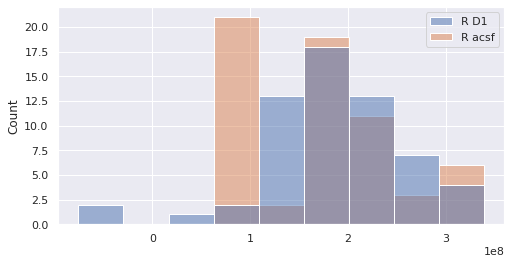

<ipython-input-112-cf8205463022>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-112-cf8205463022>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


390.0224028094293
353.3673527815709
154.97395416171847
108.51798705968464
253.8873915073893
167.75588473050712
216.0276363444008
193.6743537480358
301.32018941625796
244.12304618679994
221.86599127070104
106.45496273862432
214.90315816957994
225.91029415667194
207.35694138828129
111.48707141499142
347.1447777162209
234.93668124821488
348.9498801040303
283.1972566674573
119.85442656869341
147.33905840260036
342.34606764976576
249.68564678224848
898.1140620283105
418.52514156921967
407.287665528332
372.4947932378972
235.25385851390692
191.4058558395544
365.45178300350716
411.67141716915836
249.28550013210037
210.00234149650646
143.23076116789346
178.6273293291886
208.58121505485408
228.60750153005944
218.24896027873007
228.75996636743366
239.66935468942864
220.51429513184854
184.61412291471663
106.6172259345458
148.65531727997111
160.15789168993402
222.61698612625923
203.2164796156818
146.61027462685098
178.5162435497205
174.1423930864656
229.56078978939033
297.81133514013635
260.2460540

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65289 missing from current font.
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65289 missing from current font.


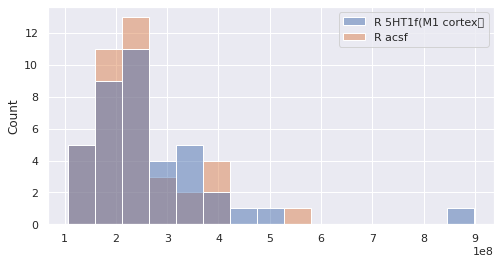

<ipython-input-112-cf8205463022>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-112-cf8205463022>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


230.29229527298023
92.15454563559021
217.1283594296291
259.2287237502071
276.6609734144337
97.76414835904778
234.2915860757128
273.8280660176894
83.67738940020143
54.02129155475039
61.18504173899443
215.347597474594
182.99811399169903
304.53640480959774
255.82165436047694
120.67778479080773
186.29946503438654
99.27329043159266
99.27329043159266
286.77608993010784


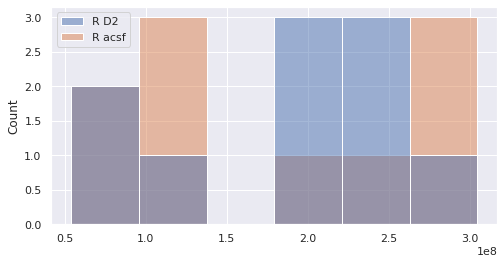

<ipython-input-112-cf8205463022>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-112-cf8205463022>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


130.51133303571982
193.99344729540013
175.26890224673025
130.22310452574976


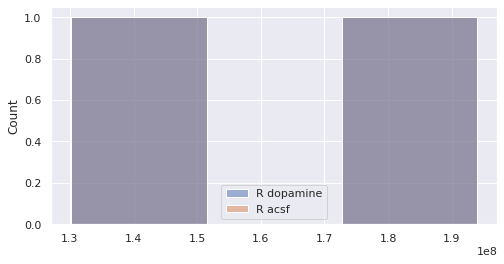

<ipython-input-112-cf8205463022>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-112-cf8205463022>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


135.39756846120295
152.10161787993073
200.89271332894577
187.8869756250662
168.12278824376665
154.34473144346597


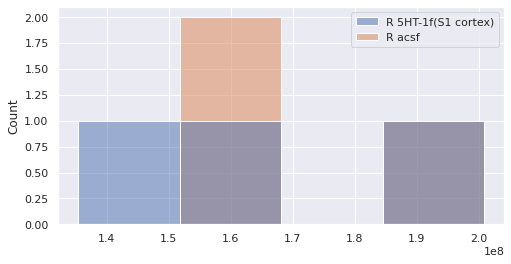

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy import stats

def calculate_resistance(condition):
  cond = condition
  file_cond = np.array(df_CC_exp[df_CC_exp['condition']==cond][df_CC_exp['drug']==False]['CC_files'])
  file_cond_acsf = np.array(df_CC_exp[df_CC_exp['condition']==cond][df_CC_exp['drug']==True]['CC_files'])
  dt = 1/20000
  searchthreshold = 0
  thresholdwindow = [1 , 0.25]
  refractory_period = 3
  derthreshold = [[1, 0.000008] ,[2, 0.000008]]
  nwindow = [np.round(thresholdwindow[0]*dt), np.round(thresholdwindow[1]/dt)]
  R_drug = []
  R_acsf = []

  # print(len(file_cond))
  for drug_file,acsf_file in zip(np.array(file_cond),np.array(file_cond_acsf)):
    # print(drug_file)
    value_dict_drug = returnVsandIs(drug_file)
    if check_for_faultycell(value_dict_drug,drug_file,'NC_16-8-17-E1-CCSTEP-DRUG.mat'):
      print('faulty')
      pass
    else:
      try:
        for trial,vals in value_dict_drug.items():
          # print(trial)
          for steps,I_ in zip(vals['V'],vals['I']):
            V = steps
            I = I_
            # if drug_file == 'NC_16-8-17-E1-CCSTEP-DRUG.mat':
            #   plt.plot(V)
            #   plt.show()

            spk_ind, thr, thr_ind = get_threshold_fontaine(np.expand_dims(V,axis=1),dt=dt,searchthreshold = searchthreshold,windown = nwindow,refractory_period = refractory_period,derthreshold =derthreshold )

            if sum(np.array(spk_ind).flatten().shape) ==0:

              # fig,ax = plt.subplots(1,2)
              I_der = np.diff(I[:int(0.8*len(I))])
              min  = np.argmin(np.diff(I[:int(0.8*len(I))]))
              max  = np.argmax(np.diff(I[:int(0.8*len(I))]))
              V_delta = np.mean(V[min-500:min-50]-V[0])
              I_delta = np.mean(I[min-500:min-50]-I[0])

              R = V_delta/I_delta
              # try:
              # df_r = pd.DataFrame({'I':pd.Series(I[max+500:min-50]),'V':pd.Series(V[max+500:min-50])})
              # R = stats.linregress(df_r.I, df_r.V)
              # ax[0].plot(I)
              # ax[0].plot(np.arange(max+50,min-50),I[max+50:min-50])
              # ax[1].plot(V)
              # plt.show()
              # except:
              #   print(spk_ind)
              #   print('problem')
              #   ax[0].plot(I)
              #   ax[1].plot(V)
              #   plt.show()
            else:
              break
          # fig,ax = plt.subplots(1,2)
          # ax[0].plot(I)
          # ax[0].plot(np.arange(max+50,min-50),I[max+50:min-50])
          # ax[1].plot(V)
          # plt.show()
          print(R/1e6)
          R_drug.append(R)
      except:
        print('problem with '+drug_file)


    value_dict_acsf = returnVsandIs(acsf_file)
    if check_for_faultycell(value_dict_acsf,acsf_file,'NC_16-8-17-E1-CCSTEP-NODRUG.mat'):
      print('faulty')
      pass
    else:
      try:
        for trial,vals in value_dict_acsf.items():
          # print(trial)
          for steps,I_ in zip(vals['V'],vals['I']):
            V = steps
            I = I_
            # if acsf_file == 'NC_16-8-17-E1-CCSTEP-NODRUG.mat':
            #   plt.plot(V)
            #   plt.show()

            spk_ind, thr, thr_ind = get_threshold_fontaine(np.expand_dims(V,axis=1),dt=dt,searchthreshold = searchthreshold,windown = nwindow,refractory_period = refractory_period,derthreshold =derthreshold )

            if sum(np.array(spk_ind).flatten().shape) ==0:

              I_der = np.diff(I[:int(0.8*len(I))])
              min  = np.argmin(np.diff(I[:int(0.8*len(I))]))
              max  = np.argmax(np.diff(I[:int(0.8*len(I))]))
              V_delta = np.mean(V[min-500:min-50]-V[0])
              I_delta = np.mean(I[min-500:min-50]-I[0])

              R = V_delta/I_delta
              # fig,ax = plt.subplots(1,2)

              # ax[0].plot(I)
              # ax[0].plot(np.arange(min-500,min-50),I[min-500:min-50])
              # ax[1].plot(V)
              # plt.show()
              # try:

              # df_r = pd.DataFrame({'I':pd.Series(I[max+500:min-50]),'V':pd.Series(V[max+500:min-50])})
              # R = stats.linregress(df_r.I, df_r.V)

              # except:
              #   print(spk_ind)
              #   print('problem')
              #   ax[0].plot(I)
              #   ax[1].plot(V)
              #   plt.show()
            else:
              break

          # fig,ax = plt.subplots(1,2)
          # ax[0].plot(I)
          # ax[0].plot(np.arange(max+50,min-50),I[max+50:min-50])
          # ax[1].plot(V)
          # plt.show()
          print(R/1e6)
          R_acsf.append(R)
      except:
        print('problem with '+acsf_file)
  R_drug = np.array(R_drug).flatten()
  R_drug = R_drug[~np.isnan(R_drug)]
  R_acsf = np.array(R_acsf).flatten()
  R_acsf = R_acsf[~np.isnan(R_acsf)]
  R_acsf = R_acsf[~np.isinf(R_acsf)]

  from sklearn.preprocessing import StandardScaler

  # print(R_acsf)
  df = pd.DataFrame({'R '+cond:pd.Series(R_drug),'R acsf':pd.Series(R_acsf)})
  # print(df)

  scaler = StandardScaler()
  scaler.fit(df)
  scaled = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled, columns=df.columns)

  sns.histplot(df)
  plt.show()
  return R_drug,R_acsf

R_drug_d1, R_acsf_d1 = calculate_resistance('D1')

R_drug_sag_m1, R_acsf_sag_m1 = calculate_resistance('5HT1f(M1 cortex）')
R_drug_d2, R_acsf_d2 = calculate_resistance('D2')
R_drug_dop, R_acsf_dop = calculate_resistance('dopamine')
R_drug_sag, R_acsf_sag= calculate_resistance('5HT-1f(S1 cortex)')


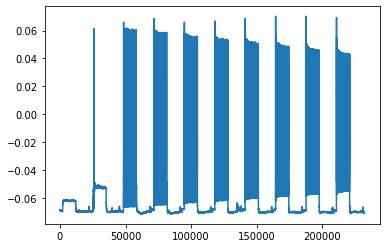

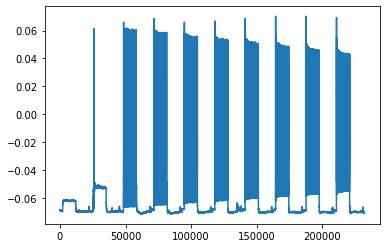

In [ ]:
data = returnVsandIs('xuan_9-7-19-E4-CCSTEP-DRUG.mat')
df = pd.DataFrame()
data_acsf = returnVsandIs('xuan_9-7-19-E4-CCSTEP-NODRUG.mat')
df_acsf = pd.DataFrame()
for k,vals in data.items():
  V = np.array(data[k]['V']).flatten()
  plt.plot(V)
  plt.show()
  for k_1,vals_k in vals.items():
    df[k_1+'_'+k] = np.array(vals_k).flatten()

# df.to_csv('Serotonin_simone_CC.csv')
for k,vals in data_acsf.items():
  V = np.array(data[k]['V']).flatten()
  plt.plot(V)
  plt.show()
  for k_1,vals_k in vals.items():
    df[k_1+'_'+k] = np.array(vals_k).flatten()

# df.to_csv('Serotonin_acsf_simone_CC.csv')

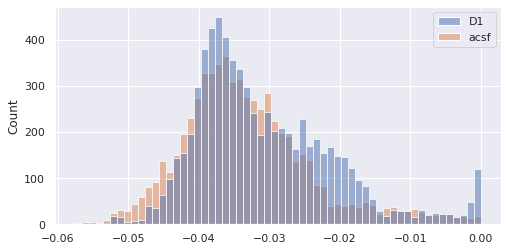

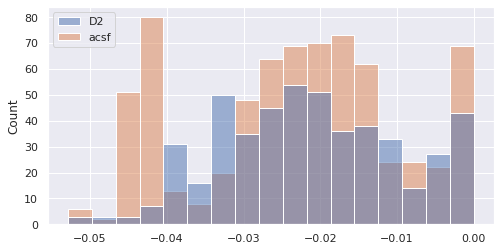

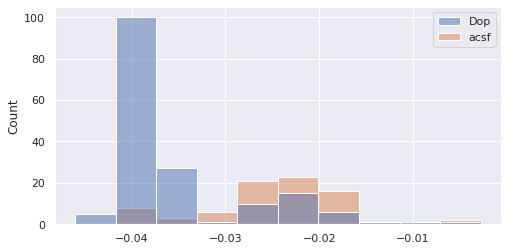

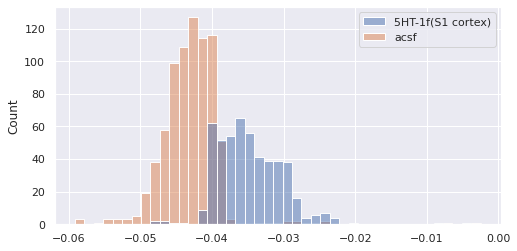

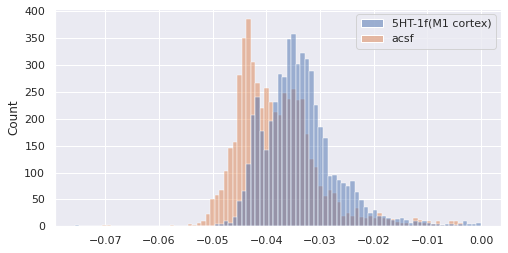

In [ ]:
def plot_ISIs_distribution(file_drug,file_acsf,cond):
  isis_1_8_drug = []
  isis_8_15_drug = []
  isis_15_drug = []

  isis_1_8_acsf = []
  isis_8_15_acsf = []
  isis_15_acsf = []


  for files in file_drug:
    for f in files['spike_info']:
      for i in f:
        # print(len(i['spks']))

        if len(i['spks'])>1 and len(i['spks'])<5 :
          for isi in np.diff(i['spks']):
            isis_1_8_drug.append(isi)
        elif len(i['spks'])>5 and len(i['spks'])<15 :

          for isi in np.diff(i['spks']):
            isis_8_15_drug.append(isi)
        elif len(i['spks'])>15:
          # print(len(i['spks']))
          for isi in np.diff(i['spks']):
            isis_15_drug.append(isi)


  for files in file_acsf:
    for f in files['spike_info']:
      for i in f:
        if len(i['spks'])>1 and len(i['spks'])<5 :
          for isi in np.diff(i['spks']):
            isis_1_8_acsf.append(isi)
        elif len(i['spks'])>5 and len(i['spks'])<15 :
          for isi in np.diff(i['spks']):
            isis_8_15_acsf.append(isi)
        elif len(i['spks'])>15:
          for isi in np.diff(i['spks']):
            isis_15_acsf.append(isi)
  df_isi1 = pd.DataFrame({cond:pd.Series(np.array(isis_1_8_drug)),'acsf':pd.Series(np.array(isis_1_8_acsf))})
  df_isi2 = pd.DataFrame({cond:pd.Series(np.array(isis_8_15_drug)),'acsf':pd.Series(np.array(isis_8_15_acsf))})
  df_isi3 = pd.DataFrame({cond:pd.Series(np.array(isis_15_drug)),'acsf':pd.Series(np.array(isis_15_acsf)[np.array(isis_15_acsf)<10000])})
  sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)

  # subplot(1,3,1)
  fig, axes = plt.subplots(1, 3,figsize = [24,8])

  sns.histplot(data=df_isi1,ax = axes[0],stat='count',common_bins=True)
  axes[0].set_title('ISI distribution for number of spikes between 1 to 8')
  sns.histplot(data=df_isi2,ax = axes[1],stat='count',common_bins=True)
  axes[1].set_title('ISI distribution for number of spikes between 8 to 15')
  sns.histplot(data=df_isi3,ax = axes[2],stat='count',common_bins=True)
  axes[2].set_title('ISI distribution for number of spikes greater than 15')
  plt.show()

def plot_threshold_dist(file_drug,file_acsf,cond):
  thrs = []
  thrs_acsf = []

  for files in file_drug:
    for f in files['spike_info']:
      for i in f:
        if (len(i['thrs'])-1)>=1:
          for thr in i['thrs']:
            thrs.append(thr)


  for files in file_acsf:
    for f in files['spike_info']:
      for i in f:
        if (len(i['thrs'])-1)>=1:
          for thr in i['thrs']:
            thrs_acsf.append(thr)
  sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)

  df = pd.DataFrame({cond:pd.Series(thrs),'acsf':pd.Series(thrs_acsf)})
  sns.histplot(data=df)
  plt.show()


plot_threshold_dist(d1,acsf_d1,'D1')

plot_threshold_dist(d2,acsf_d2,'D2')

plot_threshold_dist(dop,acsf_dop,'Dop')

plot_threshold_dist(sag,acsf_sag,'5HT-1f(S1 cortex)')

plot_threshold_dist(sag_m1,acsf_sag_m1,'5HT-1f(M1 cortex)')


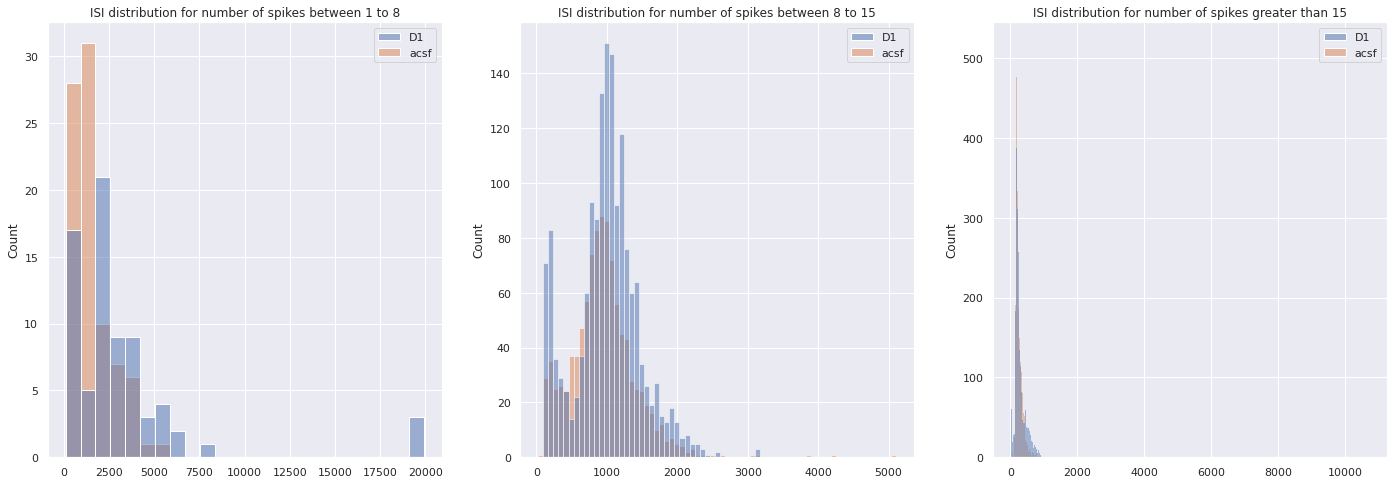

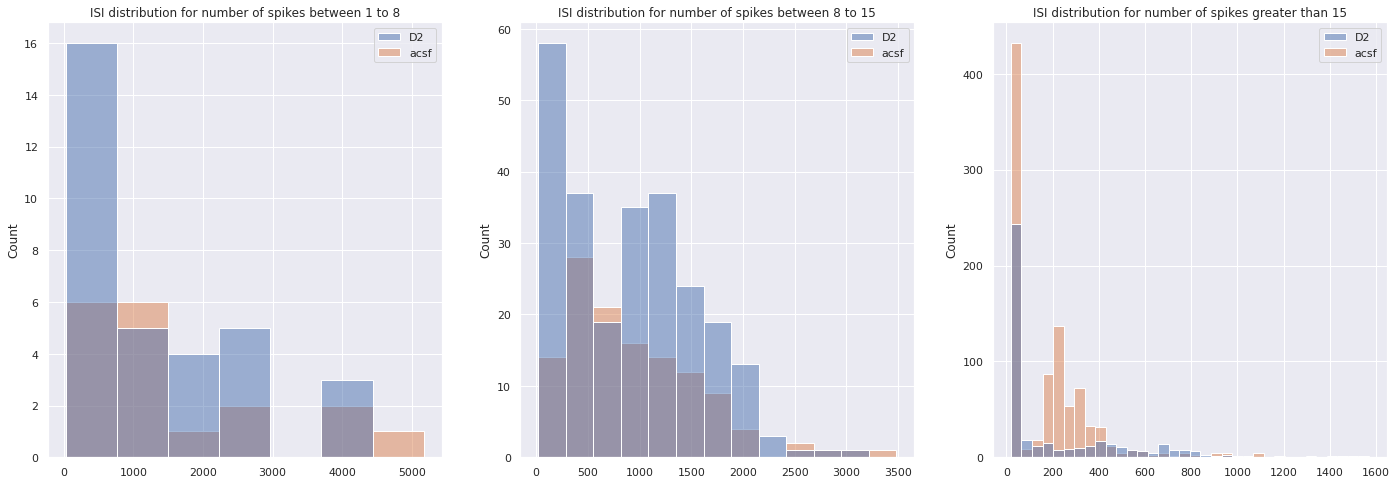

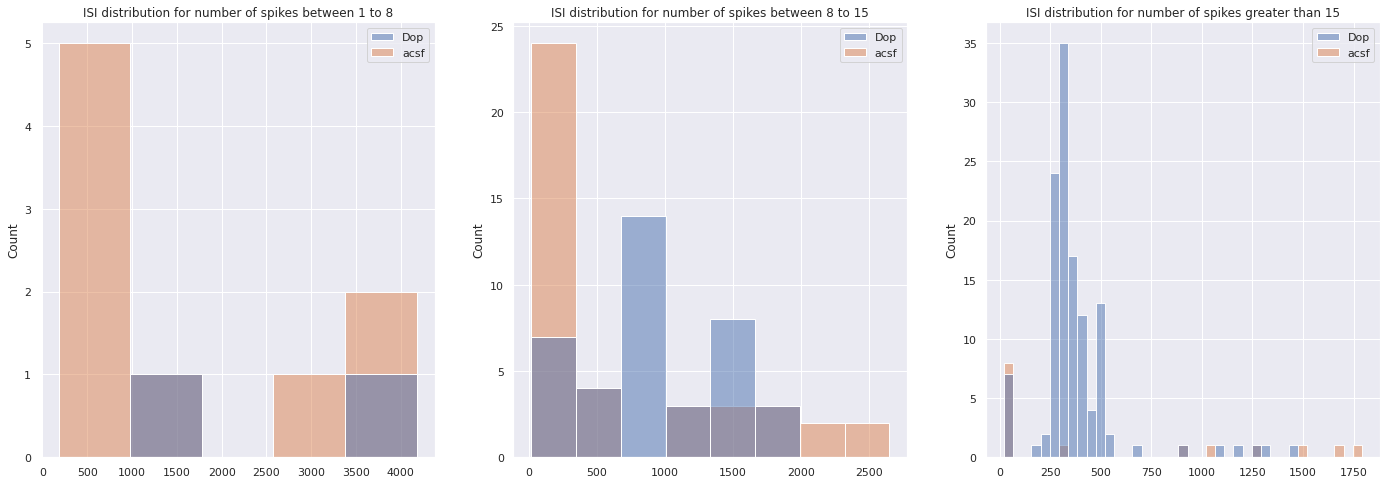

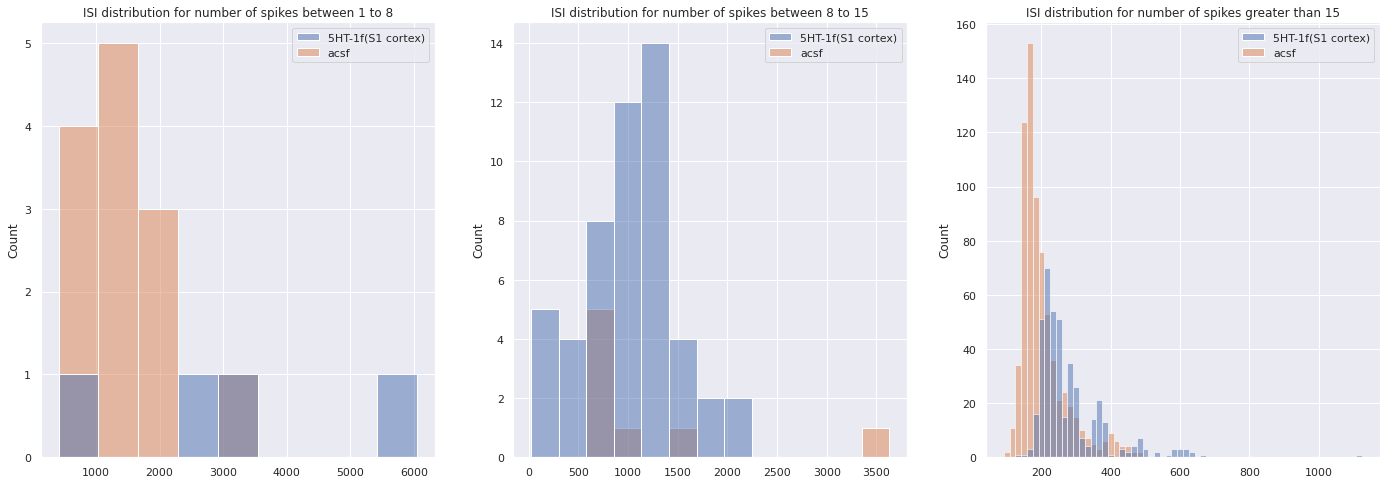

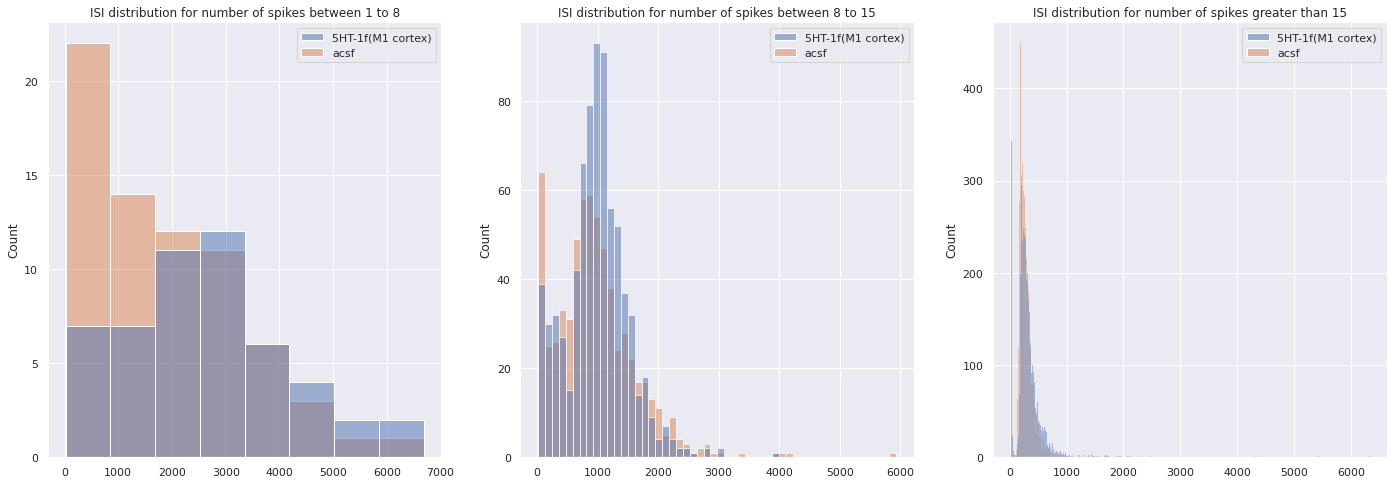

In [ ]:
plot_ISIs_distribution(d1,acsf_d1,'D1')

plot_ISIs_distribution(d2,acsf_d2,'D2')

plot_ISIs_distribution(dop,acsf_dop,'Dop')

plot_ISIs_distribution(sag,acsf_sag,'5HT-1f(S1 cortex)')

plot_ISIs_distribution(sag_m1,acsf_sag_m1,'5HT-1f(M1 cortex)')


In [ ]:
def modify_names_analyzed_cc(string):
  a = string.split('_')
  name = a[2]
  b = a[-1].split('-')
  string = ''
  for i in b[:3]:
    string+=i
  string = name+'_'+string+'_'+b[3]
  return string



# all_cc_analyzed_no_drug_trials_inh = []
# for i in all_cc_analyzed_no_drug_inh:
#   try:
#     all_cc_analyzed_no_drug_trials_inh.append(modify_names_analyzed_cc(i))
#   except:
#     print(i)
# all_cc_analyzed_no_drug_trials_exc = []
# for i in all_cc_analyzed_no_drug_exc:
#   try:
#     all_cc_analyzed_no_drug_trials_exc.append(modify_names_analyzed_cc(i))
#   except:
#     print(i)
# df_cc_nodrug_analyzed = pd.DataFrame(data = {'exc':pd.Series(np.unique(all_cc_analyzed_no_drug_trials_exc)),'inh':pd.Series(np.unique(all_cc_analyzed_no_drug_trials_inh))})
# df_cc_nodrug_analyzed

In [ ]:
df_cc_nodrug_analyzed.to_csv('/content/gdrive/MyDrive/lists/tea_cc_filenames.csv')

NameError: ignored

In [ ]:
# data  = loadmat_(all_files_cc_exc+i)
data = loadmat_(path_exc_analyzed+all_files_cc_exc_analyzed[0])
# data_sorted = data['out']['sorted']
# current = data_sorted['cell']['rep']['data']['columnar']['current']['amp']
# FR = data_sorted['cell']['rep']['data']['columnar']['FR']['abs']
# all_exc['FR'].append(FR)
# all_exc['I_steps'].append(current)

In [ ]:
def print_keys(dic):
    keys = []
    for key, value in dic.items():
        print(key)
        if isinstance(value, dict):
            print(value.keys())
            print_keys(value)
print_keys(data)

# all_keys = list()

# for key in data.keys():
#    if isinstance(data[key],dict):
#        all_keys.append(key)
#        all_keys.append(list(data[key].keys()))
#    else:
#        all_keys.append(key)

In [ ]:
def print_keys(dic):
    keys = []
    for key, value in dic.items():
        print(key)
        if isinstance(value, dict):
            print(value.keys())
            print_keys(value)
print_keys(data)


In [ ]:
def modify_names(file_name):
  str_temp = file_name
  all_parts = str_temp.split('_')
  part1 = all_parts[0]
  broken = all_parts[1].split('-')
  part2  = ''
  for j in broken[:3]:

    part2+=j
  part2+='_'
  part2+=broken[3]
  return(part1+'_'+part2)
def modify_names_fn(file_name,raw=False):
  str_temp = file_name
  all_parts = str_temp.split('_')
  if raw:
      if len(all_parts)==4:
        part1 = all_parts[0]
        part2 = all_parts[1].replace('-','')
        part3 = all_parts[2]
        return (part1+'_'+part2+'_'+part3)
      else:
        part1 = all_parts[0]
        part2 = all_parts[1].replace('-','')
        part3 = all_parts[-3]
        return (part1+'_'+part2+'_'+part3)

  else:
    if len(all_parts)>3:
      part1 = all_parts[0]
      part2 = all_parts[1]
      part3 = all_parts[-1]
      return (part1+'_'+part2+'_'+part3)
    else:
      part1 = all_parts[0]
      part2 = all_parts[1].replace('-','')
      part3 = all_parts[-1]
      return (part1+'_'+part2+'_'+part3)

def comparefiles_by_cond(experimenter):
  all_cc = []
  for i in all_cc_complete:
    all_cc.append(modify_names(i))
  path = '/content/gdrive/MyDrive/lists/all_files_new.csv'

  all_files_fn = pd.read_csv(path)
  all_files_fn = np.unique(all_files_fn.groupby('experimenter').get_group(experimenter)['experimentname'])
  all_fn = []
  for i in all_files_fn:
    all_fn.append(modify_names_fn(i))
  matrix = np.zeros((len(all_cc),len(all_fn)))
  matches = 0 #.split('_')[1]
  matching_files = []

  for i in range(len(np.sort(all_cc))):
    for j in range(len(np.sort(all_fn))):
      if all_cc[i] == all_fn[j]:
        matches+=1
        matching_files.append(all_cc[i])
        if i==j:
          matrix[i,j] +=10
        else:
          matrix[i,j] +=1
  return matching_files

all_cc = []
for i in all_files_cc:
    all_cc.append(modify_names(i))

all_fn = []
for i in all_files_fn:

  all_fn.append(modify_names_fn(i))


In [ ]:
all_fn_raw_mod = []
for j in filter_acuteslices:
  all_fn_raw_mod.append(modify_names_fn(j,raw=True))

In [ ]:
all_fn_raw_mod = np.unique(all_fn_raw_mod)

In [ ]:
df.to_csv('/content/gdrive/MyDrive/lists/cc_fn.csv')
df

,FN,CC,matching
0,NC_170615_E1,KK_30817_E6,NC_171017_E2
1,NC_170620_E1,NC_101017_E4,NC_171017_E4
2,NC_170623_E4,NC_101017_E5,Payam_101019_E2
3,NC_170626_E1,NC_111017_E1,Payam_101019_E3
4,NC_170626_E2,NC_111017_E3,Payam_101019_E4
...,...,...,...
318,xuan_9519_E4,NaN,NaN
319,xuan_9919_E1,NaN,NaN
320,xuan_9919_E2,NaN,NaN
321,xuan_9919_E3,NaN,NaN


In [ ]:
counts_step_cc = {'NC':0,'xuan':0,'asli':0,'Payam':0}
counts_step_fn = {'NC':0,'xuan':0,'asli':0,'Payam':0}
counts_step_match = {'NC':0,'xuan':0,'asli':0,'Payam':0}

for i in matching_files:
  for j in counts_step_match.keys():
    if j in i:
      counts_step_match[j]+=1

for i in all_cc:
  for j in counts_step_cc.keys():
    if j in i:
      counts_step_cc[j]+=1

for i in all_fn:
  for j in counts_step_fn.keys():
    if j in i:
      counts_step_fn[j]+=1

print(counts_step_cc)
print(counts_step_fn)
print(counts_step_match)

print(matching_files)


{'NC': 44, 'xuan': 146, 'asli': 76, 'Payam': 52}
{'NC': 138, 'xuan': 121, 'asli': 40, 'Payam': 26}
{'NC': 2, 'xuan': 37, 'asli': 33, 'Payam': 17}
['NC_171017_E2', 'NC_171017_E4', 'Payam_101019_E2', 'Payam_101019_E3', 'Payam_101019_E4', 'Payam_101019_E5', 'Payam_12919_E1', 'Payam_12919_E4', 'Payam_161019_E3', 'Payam_161019_E4', 'Payam_161019_E5', 'Payam_24919_E1', 'Payam_25919_E1', 'Payam_25919_E2', 'Payam_26919_E1', 'Payam_26919_E2', 'Payam_5919_E1', 'Payam_5919_E2', 'Payam_5919_E3', 'asli_12719_E2', 'asli_12719_E3', 'asli_18719_E1', 'asli_2819_E1', 'asli_2819_E2', 'asli_2819_E3', 'asli_23719_E2', 'asli_23719_E3', 'asli_23719_E5', 'asli_24719_E4', 'asli_24719_E5', 'asli_25719_E1', 'asli_25719_E2', 'asli_25719_E3', 'asli_25719_E4', 'asli_30719_E1', 'asli_31719_E1', 'asli_31719_E2', 'asli_31719_E3', 'asli_31719_E4', 'asli_5719_E3', 'asli_5719_E4', 'asli_5819_E1', 'asli_5819_E2', 'asli_5819_E3', 'asli_5819_E4', 'asli_5819_E7', 'asli_6819_E1', 'asli_6819_E2', 'asli_6819_E3', 'asli_6819_E4'

In [ ]:
#@title all ephys functions
from pandas.core.arrays.numeric import T
from math import isnan
def remove_nan(data):
  ind = ~np.isnan(data)
  data_ = data[ind]
  return data_
def rolling_avg(data):
  start = 0
  length = len(data)//10
  end = len(data)
  finish = False
  avg = []

  if length ==0 :
    return np.mean(data[start:end])
  else:
    while finish!=True:
      if start+length <end:
        avg.append(np.mean(data[start:start+length]))
        start+=length
      else:
        avg.append(np.mean(data[start:end]))
        finish= True

    return avg


def get_Vm(data):
  Vm = []
  V = data['membrane_potential']
  thr = data['thresholds']
  thr_ind = data['thresholdindices']
  spikes = data['spikeindices']
  ind = ~np.isnan(thr)
  spikes = spikes[ind]
  thr = thr[ind]
  thr_ind = thr_ind[ind]

  for i,j in zip(thr_ind,thr):
    Vm.append(V[int(i)+1:int(i)+50])
  return np.mean(Vm), Vm, np.mean(V)

def get_dvdt(data):
  dvdt_p = []
  dvdt_n = []

  for i in data:
    dv_ = np.diff(i)
    posp = np.where(dv_>0)
    dvdt_ind = np.zeros_like(dv_,dtype=bool)
    dvdt_ind[posp] = True
    posp = dvdt_ind
    posn = ~posp
    dvdt_p.append(np.mean(dv_[posp]))
    dvdt_n.append(np.mean(dv_[posn]))

  return np.mean(dvdt_p),np.mean(dvdt_n)

def sub_threhold_resistance(data):
  spikes = data['spikeindices']
  V = data['membrane_potential'][:spikes[0]]
  I = data['input_current'][:spikes[0]]
  R = np.mean(V/I)
  return R

def get_thresholds(data):
  ind = ~np.isnan(data['thresholds'])
  return np.mean(data['thresholds'][ind])

def get_isi(data):
  ind = ~np.isnan(data['thresholds'])
  return np.mean(np.diff(data['spikeindices'][ind]))

def get_adaptation(data):
  ind = ~np.isnan(data['thresholds'])
  return np.mean(np.diff(data['thresholds'][ind]))

def get_AP_peak(data):
  max_v = []
  for i in data:
    max_v.append(np.max(i))
  return np.mean(max_v)

def get_AP_peak_adaptation(data):
  max_v = []
  for i in data:
    max_v.append(np.max(i))
  return np.mean(np.diff(max_v))

def get_AP_width(data):
  thr_ind = data['thresholdindices']
  thr = data['thresholds']
  ind = ~np.isnan(thr_ind)
  spks = data['spikeindices'][ind]
  thr =thr[ind]
  thr_ind=thr_ind[ind]
  V = data['membrane_potential']
  peak = 0
  width = []
  for i,j in zip(spks,thr_ind):
    try:
      spike_wf = V[int(j):int(j)+100]
      # plt.plot(spike_wf)
      left  = V[int(j):i]
      right_ind = i-int(j)
      right = spike_wf[right_ind:]
      half_height = V[i]/2
      left_first = np.where(left<=half_height)
      right_first = np.where(right<=half_height)
      width.append((int(i-j)+right_first[0][0]+1)-(left_first[0][-1]))
    except:
      pass
  return np.mean(width)

def hyperpolarized_value(data):
  return np.min(data['membrane_potential'])

def first_spike(data):
  return data['thresholdindices'][0]

def get_up_down_ratio(data):
  if len(data['Analysis'])>1 and type(data['Analysis']) ==list:
    avg_up = []
    avg_down = []
    for i in data['Analysis']:
      avg_up.append(i['nup'])
      avg_down.append(i['ndown'])
  else:
    avg_up = data['Analysis']['nup']
    avg_down = data['Analysis']['ndown']
  return np.nanmean(np.array(avg_up)/np.array(avg_down))

def subthreshold(data,subthreshold =False,plot=False):
    V= data['membrane_potential']
    I= data['input_current']
    spikes = data['spikeindices']
    if data['input_generation_settings']['tau'] == 250:
        left = 20
        right = 30
    else:
        left = 20
        right = 20
    empty_cell = []
    for i in spikes:
        empty_cell.append([np.arange(i-left,i+right)])
        V1 = V[i-left]
        V2 = V[i+right]
        if V1!=V2:
            div = (V2-V1)/(left+right)
            V[i-left:i+right] = np.arange(V1,V2,div)[:left+right]
        else:
            V[i-left:i+right] = np.ones((1,left+right))*V1
        I1 = I[i-left]
        I2 = I[i+right]
        if I1!=I2:
            divI = (I2-I1)/(left+right)
            I[i-left:i+right] = np.arange(I1,I2,divI)[:left+right]
        else:
            I[i-left:i+right] = np.ones((1,left+right))*I1
    V_ = V
    I_ = I
    tailored_spikes = np.ndarray.flatten(np.array(empty_cell))
    zero_spikes = np.zeros(np.size(V))
    zero_spikes[tailored_spikes] = True
    if subthreshold == True:
        zero_spikes = ~zero_spikes
    return np.mean(V_)

def ISI_adaptation_index(data):

  ind = ~np.isnan(data['thresholds'])
  ISI = np.diff(data['spikeindices'][ind])
  len_isi  = len(ISI)
  fac = len_isi//10
  avgs = []
  for i in range(10):
    avg_ = np.mean(ISI[i*fac:(i+1)*fac])
    avgs.append(avg_)
  factors = []
  for j in range(9):
    factors.append(avgs[j]/avgs[j+1])
  return (np.mean(factors))

def threshold_adaptation_index(data):
  ind = ~np.isnan(data['thresholds'])
  thr = np.diff(data['thresholds'][ind])
  len_thr  = len(thr)
  fac = len_thr//10
  avgs = []
  for i in range(10):
    avg_ = np.mean(thr[i*fac:(i+1)*fac])
    avgs.append(avg_)
  factors = []
  for j in range(9):
    factors.append(avgs[j]/avgs[j+1])
  return (np.mean(factors))

def PSTH(data):
  V_zero = np.zeros_like(data['membrane_potential'])
  thr = data['thresholdindices']
  ind = ~np.isnan(thr)
  spks = data['spikeindices'][ind]
  V_zero[spks] = 1
  count_spk = []
  start = 0
  width = 50000
  end = len(V_zero)
  run =True
  while run:
    if start+width>end:
      count_spk.append(sum(V_zero[start:end]))
      run=False
    else:
      count_spk.append(sum(V_zero[start:start+width]))
      start=start+width
  return np.mean(count_spk)

def get_inst_fr(data):
  return np.mean( 1/(np.diff(data['spikeindices'])))

def get_firing_rate(data):
  return np.mean(data['firing_rate'])

def spike_frequency_adaptation(data):

  V_zero = np.zeros_like(data['membrane_potential'])
  thr = data['thresholdindices']
  ind = ~np.isnan(thr)
  spks = data['spikeindices'][ind]
  V_zero[spks] = 1
  count_spk = []
  start = 0
  width = 50000
  end = len(V_zero)
  run =True
  while run:
    if start+width>end:
      count_spk.append(sum(V_zero[start:end]))
      run=False
    else:
      count_spk.append(sum(V_zero[start:start+width]))
      start=start+width
  return np.mean(np.diff(count_spk))

def get_impedence(data):
  I_acsf = data['input_current']
  V_acsf = data['membrane_potential']
  spk_acsf,V_acsf,I_acsf = return_stiched_spike_train(data)
  imp = overdracht_wytse(0.01,I_acsf,V_acsf,20001,20001,1)
  return np.mean(imp)




In [ ]:
#@title compilation of all ephys functions
def return_all_ephys_dict(cond, experimenter=None):
  def get_ephys_vals(data_i):
    ephys_data = []

    try:
      Vm_avg,Vm,_ = get_Vm(data_i)
      dvdt_p,dvdt_n = get_dvdt(Vm)
      resistance =sub_threhold_resistance(data_i)
      thr = get_thresholds(data_i)
      adaptation = get_adaptation(data_i)
      isi = get_isi(data_i)
      peak = get_AP_peak(Vm)
      peak_adaptation = get_AP_peak_adaptation(Vm)
      ap_width = get_AP_width(data_i)
      hyp_value = hyperpolarized_value(data_i)
      fist_spike = first_spike(data_i)
      up_down_ratio = get_up_down_ratio(data_i)
      isi_adaptation = ISI_adaptation_index(data_i)
      thr_adp_ind = threshold_adaptation_index(data_i)
      psth = PSTH(data_i)
      int_fr = get_inst_fr(data_i)
      fr = get_firing_rate(data_i)
      sub_thr  = subthreshold(data_i)
      spk_fr_adp = spike_frequency_adaptation(data_i)
      imp  = get_impedence(data_i)
      ephys_data.append([Vm_avg,
                                dvdt_p,
                                dvdt_n,
                                resistance,
                                thr,
                                adaptation,
                                isi,
                                peak,
                                peak_adaptation,
                                ap_width,
                                hyp_value,
                                fist_spike,
                                up_down_ratio,
                                isi_adaptation,
                                thr_adp_ind,
                                psth,
                                int_fr,
                                fr,
                                sub_thr,
                                spk_fr_adp,
                                imp])
    except:
      ephys_data.append([Vm_avg,
                                dvdt_p,
                                dvdt_n,
                                resistance,
                                thr,
                                adaptation,
                                isi,
                                peak,
                                peak_adaptation,
                                ap_width,
                                hyp_value,
                                fist_spike,
                                up_down_ratio,
                                isi_adaptation,
                                thr_adp_ind,
                                psth,
                                int_fr,
                                fr,
                                sub_thr,
                                spk_fr_adp,
                                imp])

    return ephys_data
  all_ephys_with_cond = {}
  path_i = '/content/gdrive/MyDrive/Analyzed/'
  if type(cond) != list:
    raise ValueError('condition should be a list even if a single value is provided')
  cond_i = cond #['ACSF','aCSF']
  new_a = join_cond(cond_i)
  if experimenter !=None:
    new_a = new_a.groupby('experimenter').get_group(experimenter)
  new_a_inh = new_a.groupby('tau').get_group(50)
  new_a_exc = new_a.groupby('tau').get_group(250)

  exp_name_inh = np.array(new_a_inh['experimentname'])
  trials_inh = np.array(new_a_inh['trialnr'])
  exp_name_exc = np.array(new_a_exc['experimentname'])
  trials_exc = np.array(new_a_exc['trialnr'])
  all_ephys_data_inh = []
  all_ephys_data_exc = []
  all_ephys_data_inh_acsf = []
  all_ephys_data_exc_acsf = []
  problem_cell = []
  count = 0

  for i,j in zip(exp_name_exc,trials_exc-1):
      # try:
        count+=1
        print(count)
        try:
          data  = loadmat_(path_i + i + '_analyzed.mat')
        except:
          data  = loadmat_(path_i + 'Copy of ' + i + '_analyzed.mat')
        for instance in data:
          if instance['input_generation_settings']['condition'] in ['ACSF','aCSF']:
            all_ephys_data_exc_acsf.append(get_ephys_vals(instance))
        try:
          data_i = data[j]
        except:
          if len(data)==1:
            data_i = data
          else:
            problem_cell.append(i)
            pass
        print(i, data_i['input_generation_settings']['condition'])
        all_ephys_data_exc.append(get_ephys_vals(data_i))
      # except:
      #   print('except')
      #   pass


  for i,j in zip(exp_name_inh,trials_inh-1):
      # try:
        count+=1
        try:
          data  = loadmat_(path_i + i + '_analyzed.mat')
        except:
          data  = loadmat_(path_i + 'Copy of ' + i + '_analyzed.mat')
        for instance in data:
          if instance['input_generation_settings']['condition'] in ['ACSF','aCSF']:
            all_ephys_data_inh_acsf.append(get_ephys_vals(instance))
        try:
          data_i = data[j]
        except:
          if len(data)==1:
            data_i = data
          else:
            problem_cell.append(i)
            pass
        print(i, data_i['input_generation_settings']['condition'])
        all_ephys_data_inh.append(get_ephys_vals(data_i))
      # except:
      #   pass


  all_ephys_with_cond['exc'] = all_ephys_data_exc
  all_ephys_with_cond['inh'] = all_ephys_data_inh
  all_ephys_with_cond['exc_acsf'] = all_ephys_data_exc_acsf
  all_ephys_with_cond['inh_acsf'] = all_ephys_data_inh_acsf
  all_ephys_with_cond['cond'] = cond
  return all_ephys_with_cond